In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, BatchNormalization, Permute
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
from evaluator import Evaluator

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

## Utility

In [2]:
class DDPGProcessor(Processor):
    def process_action(self, actions):
        exp = np.exp(actions)
        scaled_action = exp / np.sum(exp)
        return np.random.choice([0,1], p=scaled_action)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if self.training and np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super(CustomDDPGAgent, self).select_action(state)
        


### Forex-v0 default

In [3]:
window_size=24
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=window_size)

env = env_creator()
obs = env.reset()
env_shape=obs.shape
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = 2
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

#criticModel()[0].summary()
def agent_creator():
    actor, critic, action_input = simple_critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
112/989 [==>...........................] - ETA: 3s - reward: -1.2411 - cumulative_reward: -83.1902WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 5s 5ms/step - reward: 0.6717 - cumulative_reward: 259.3322
train 1 completed. took 7.054 seconds, total_reward: 664.7999999999922 total_profit: 0.7151990723787167
min reward: -123.10000000000043, max reward: 178.6000000000021, mean_reward: 0.13433016771064704


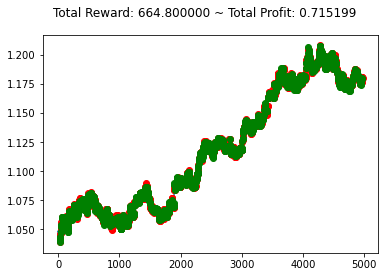

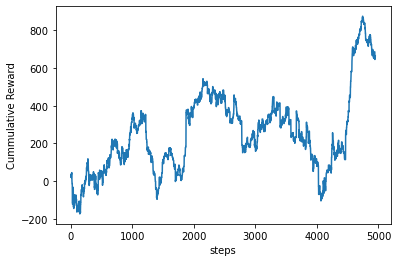

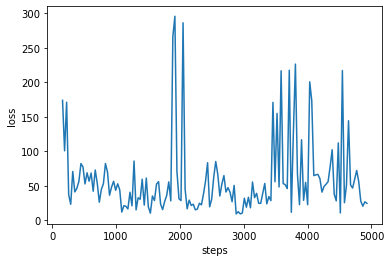

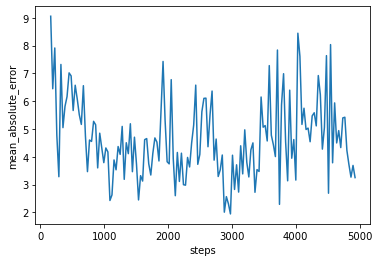

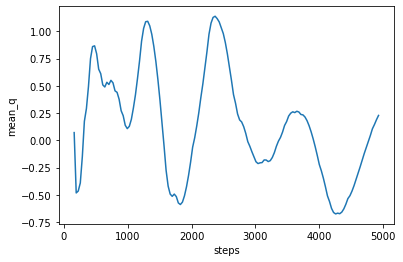

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 9s 9ms/step - reward: 20.2359 - cumulative_reward: -352.2482
train 2 completed. took 19.007 seconds, total_reward: -855.3000000000586 total_profit: 0.6740082242947821
min reward: -168.70000000000164, max reward: 122.70000000000225, mean_reward: -0.1728227924833418


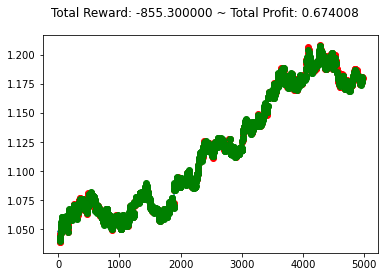

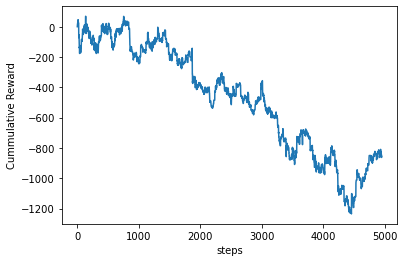

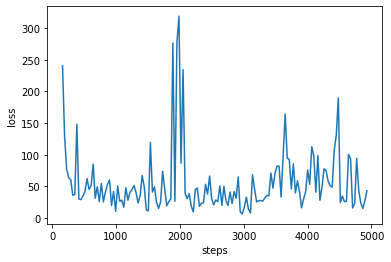

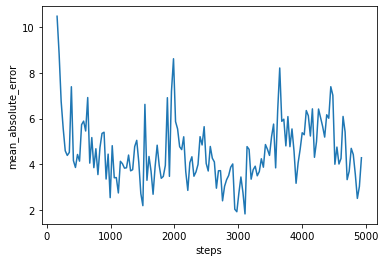

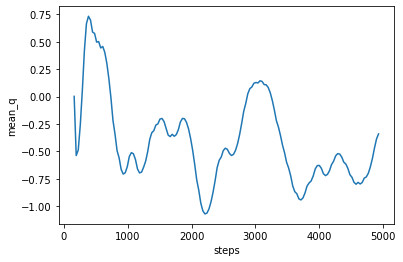

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 8s 8ms/step - reward: 16.6934 - cumulative_reward: -1426.1056
train 3 completed. took 32.510 seconds, total_reward: -2382.1000000000695 total_profit: 0.6384896506314157
min reward: -203.40000000000026, max reward: 149.49999999999795, mean_reward: -0.4813295615275954


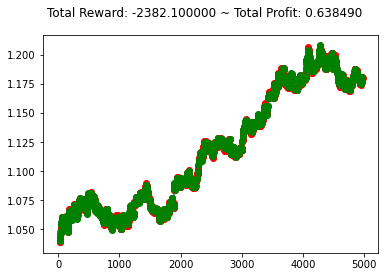

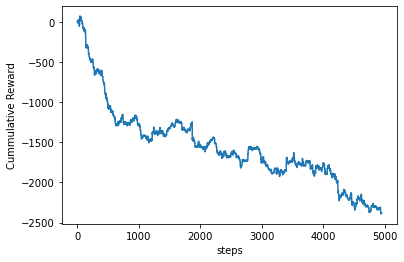

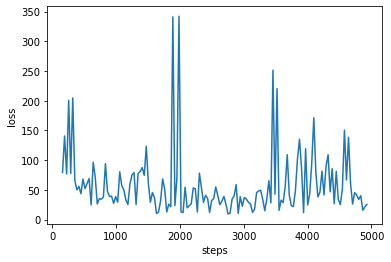

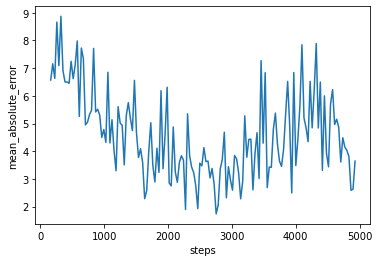

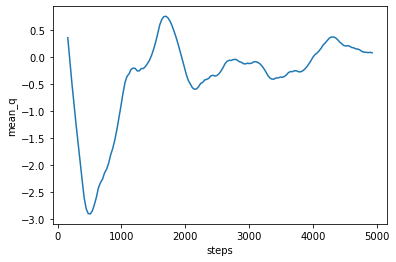

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 10s 10ms/step - reward: -8.6121 - cumulative_reward: 317.1850
train 4 completed. took 46.453 seconds, total_reward: -11.999999999969276 total_profit: 0.7108569376330387
min reward: -168.70000000000164, max reward: 121.6000000000017, mean_reward: -0.0024247322691390736


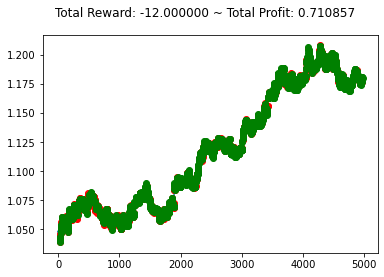

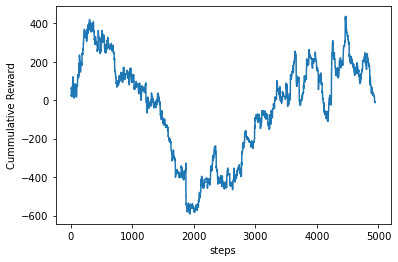

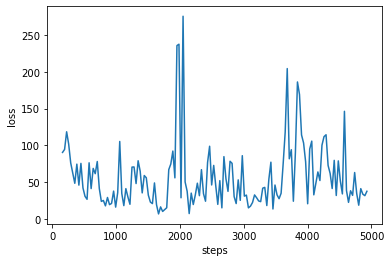

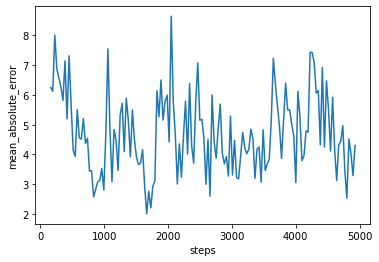

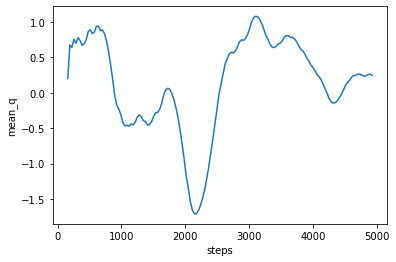

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 9s 9ms/step - reward: -27.7673 - cumulative_reward: -591.8283
train 5 completed. took 63.222 seconds, total_reward: -1452.3000000001396 total_profit: 0.6725005810367088
min reward: -104.69999999999757, max reward: 154.50000000000185, mean_reward: -0.2934532228733359


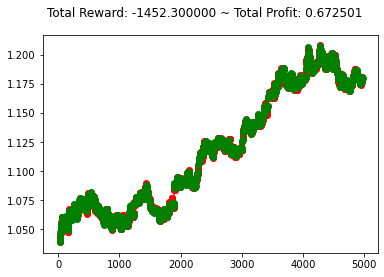

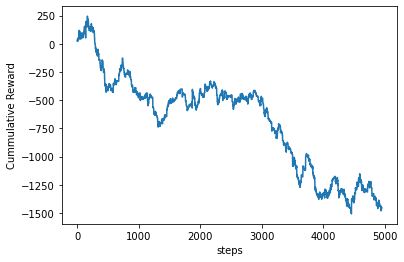

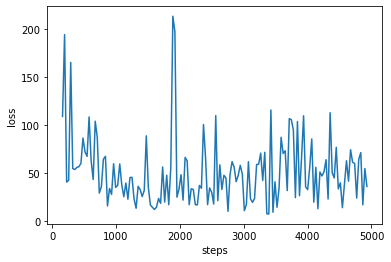

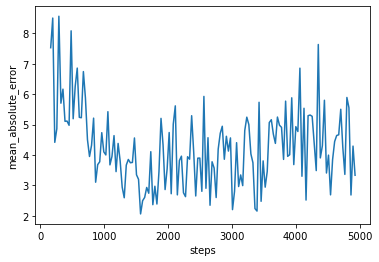

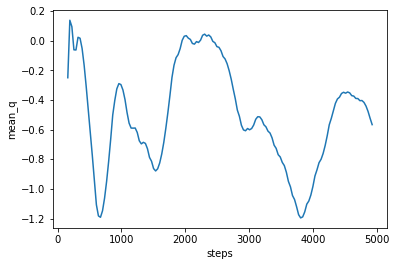

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 13ms/step - reward: 19.0337 - cumulative_reward: 255.2748
train 6 completed. took 82.942 seconds, total_reward: 528.299999999902 total_profit: 0.7378917030075908
min reward: -98.60000000000201, max reward: 205.7999999999982, mean_reward: 0.10674883814910123


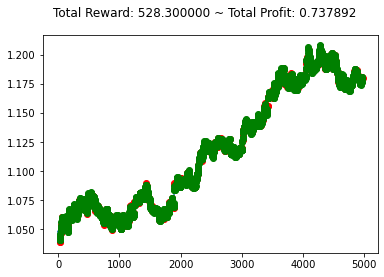

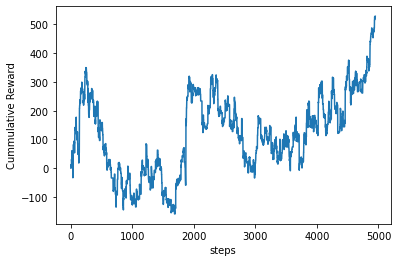

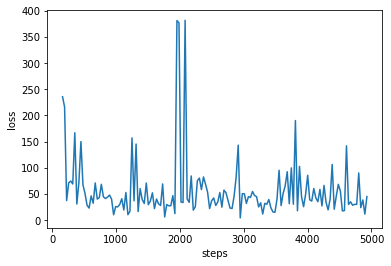

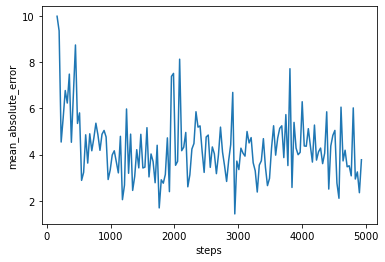

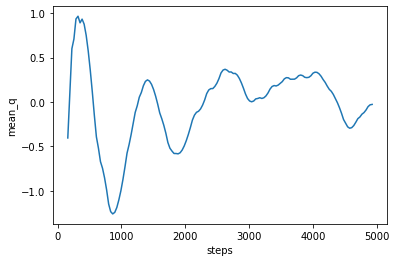

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 12ms/step - reward: 22.6321 - cumulative_reward: 624.94051s - reward: 26.0307 - cumulative_reward
train 7 completed. took 103.590 seconds, total_reward: 724.6000000000704 total_profit: 0.7347430078982908
min reward: -168.70000000000164, max reward: 101.70000000000235, mean_reward: 0.14641341685190348


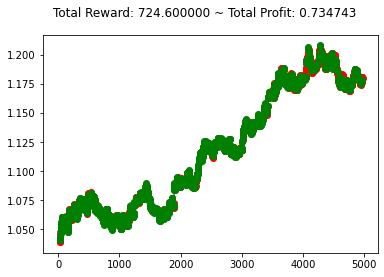

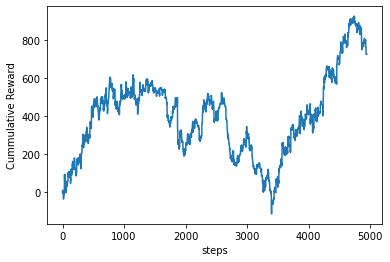

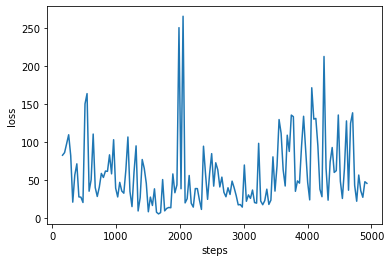

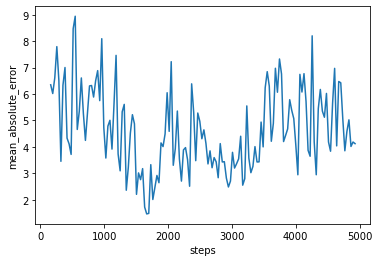

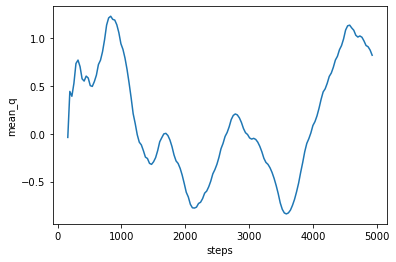

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 11s 11ms/step - reward: 36.5982 - cumulative_reward: 807.6445
train 8 completed. took 125.699 seconds, total_reward: 1185.999999999959 total_profit: 0.751653986537522
min reward: -106.19999999999851, max reward: 181.00000000000006, mean_reward: 0.2396443726005171


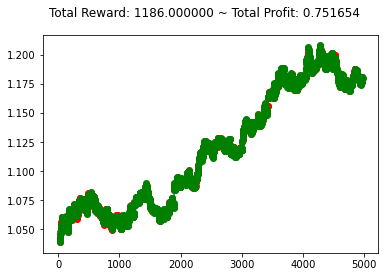

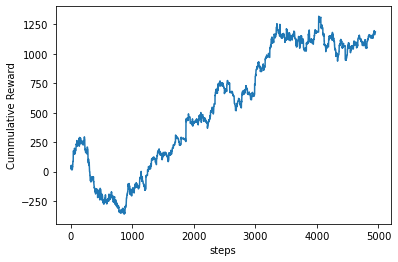

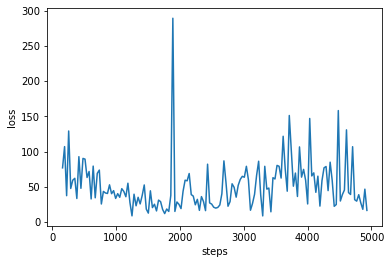

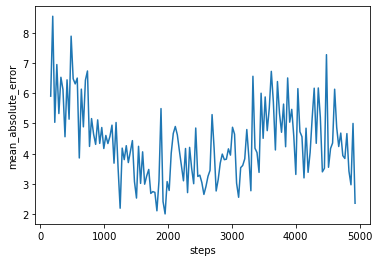

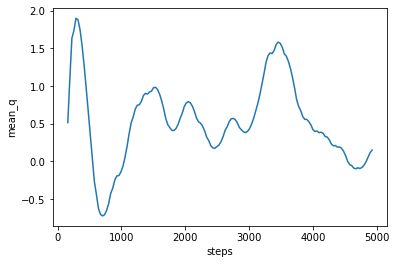

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 16s 16ms/step - reward: -0.9152 - cumulative_reward: -508.0708
train 9 completed. took 152.208 seconds, total_reward: -905.9000000000714 total_profit: 0.6782924044865137
min reward: -147.20000000000067, max reward: 122.70000000000225, mean_reward: -0.18304708021824032


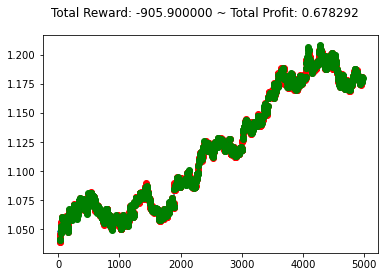

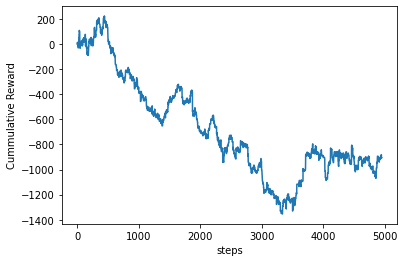

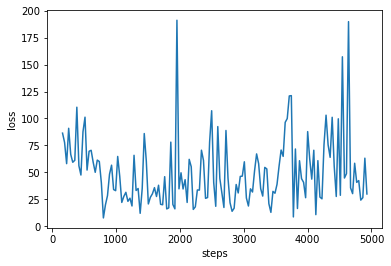

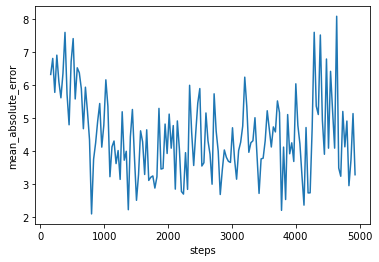

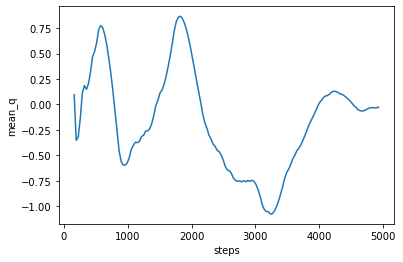

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: 19.0016 - cumulative_reward: 74.3236
train 10 completed. took 178.758 seconds, total_reward: -394.2999999999862 total_profit: 0.6970767410968041
min reward: -137.40000000000086, max reward: 114.00000000000077, mean_reward: -0.0796726611436626


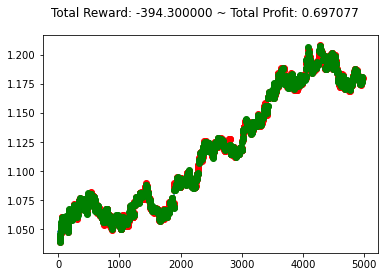

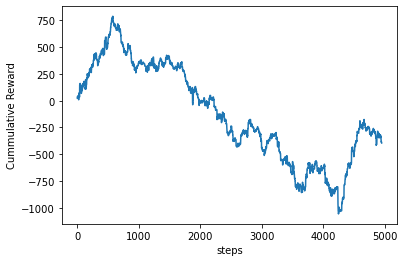

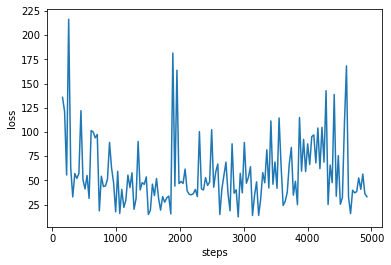

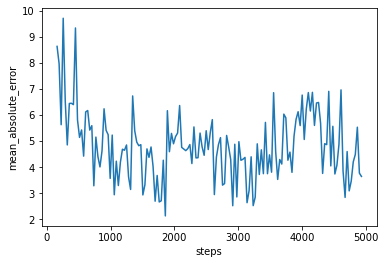

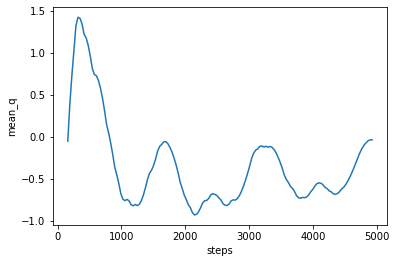

In [4]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=10)


average of total_reward across trainings: [-289.82]


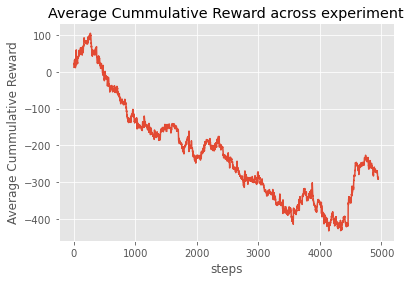

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
184/199 [==========================>...] - ETA: 0s - reward: -30.2513 - cumulative_reward: 204.2058Episode 1: reward: 566.500, steps: 999
test completed. total_reward: 566.5000000000051 total_profit: 0.9811710994876922
min reward: -83.99999999999963, max reward: 105.89999999999877, mean_reward: 0.5670670670670722


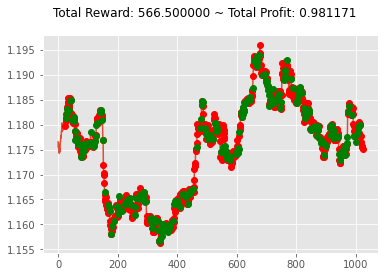

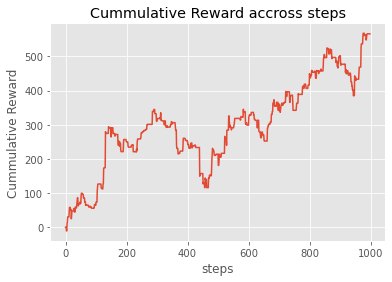

In [5]:
e.process_train_result()
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=window_size))

### Forex-v0 full feature

In [6]:
from custom_env import ForexV0FullFeature
def env_creator():
    return ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(50, 5000), window_size=window_size)
env = env_creator()
obs = env.reset()
env_shape=obs.shape
print(env_shape)
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = 2
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

#criticModel()[0].summary()
def agent_creator():
    actor, critic, action_input = simple_critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

(24, 15)


starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: 21.4192 - cumulative_reward: -810.3060
train 1 completed. took 29.889 seconds, total_reward: -475.9000000000464 total_profit: 0.6825335301835648
min reward: -107.29999999999906, max reward: 168.70000000000164, mean_reward: -0.09616084057386268


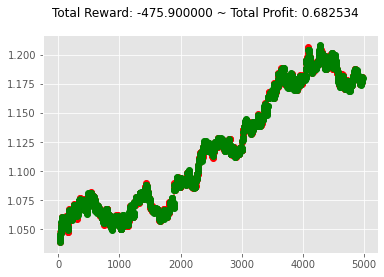

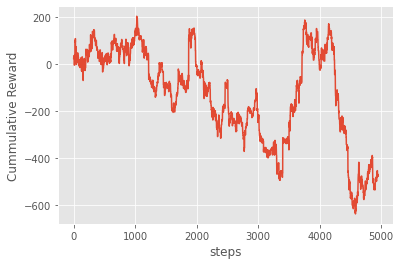

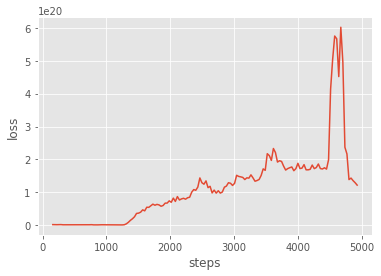

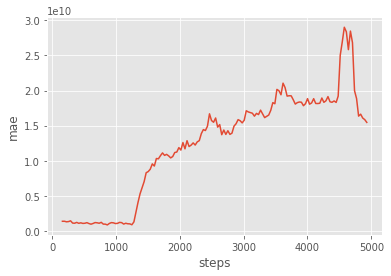

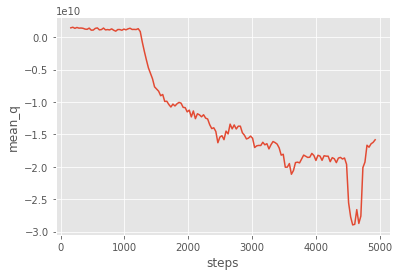

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 19s 19ms/step - reward: 9.7870 - cumulative_reward: -989.3771
train 2 completed. took 65.900 seconds, total_reward: -1992.500000000046 total_profit: 0.6157060188021735
min reward: -195.19999999999982, max reward: 76.80000000000132, mean_reward: -0.40260658718934045


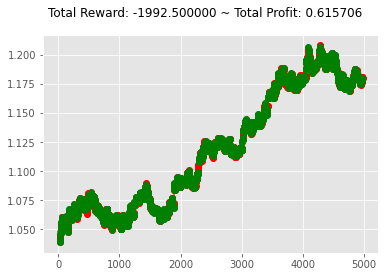

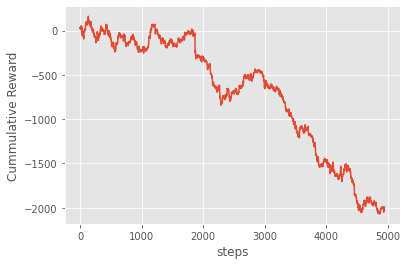

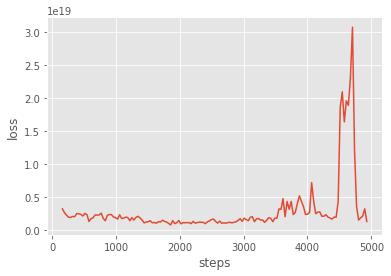

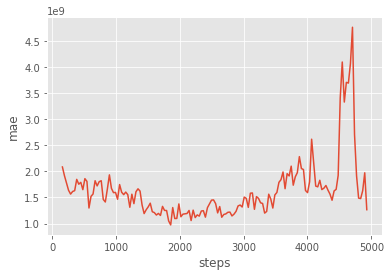

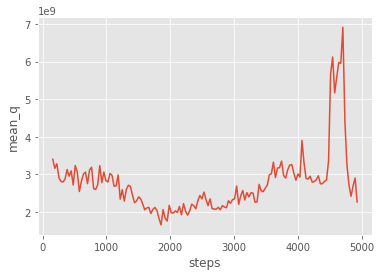

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 20s 20ms/step - reward: 2.6493 - cumulative_reward: -849.8302
train 3 completed. took 104.801 seconds, total_reward: -1039.9999999999327 total_profit: 0.6884826235655449
min reward: -114.70000000000091, max reward: 106.19999999999851, mean_reward: -0.21014346332591083


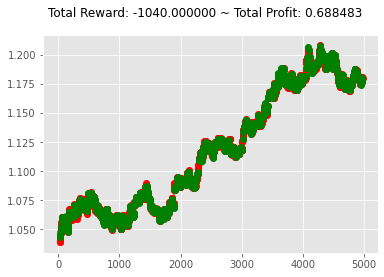

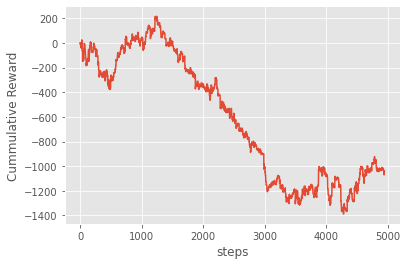

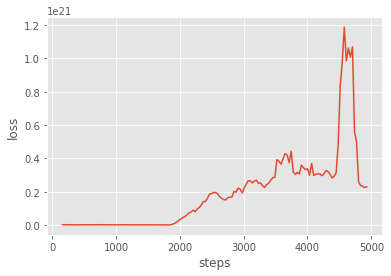

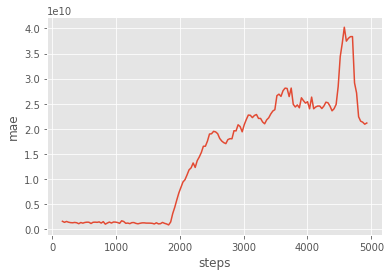

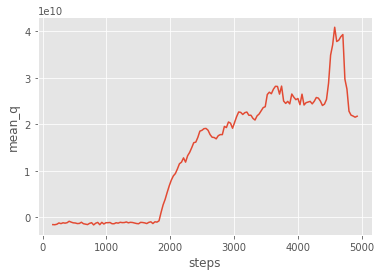

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 22s 22ms/step - reward: 0.1034 - cumulative_reward: -141.6719
train 4 completed. took 147.426 seconds, total_reward: 102.30000000002863 total_profit: 0.7246660982652524
min reward: -197.1999999999996, max reward: 114.60000000000025, mean_reward: 0.020670842594469312


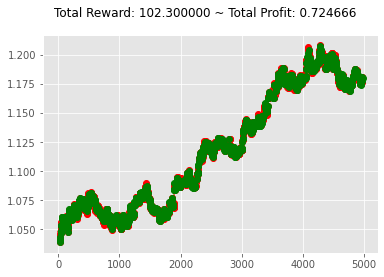

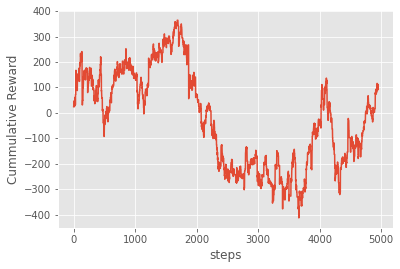

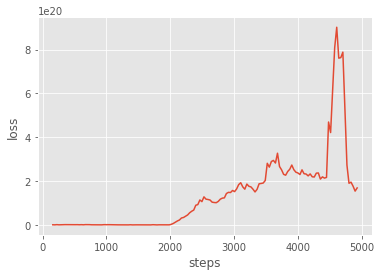

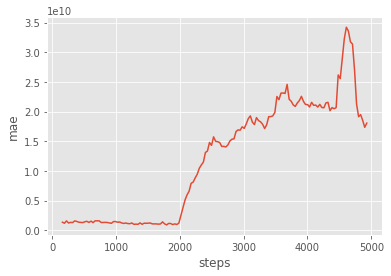

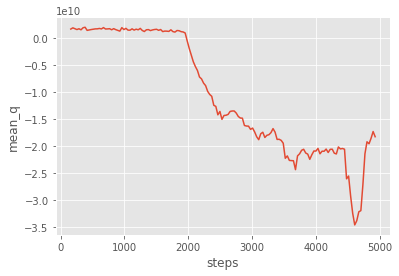

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 23s 24ms/step - reward: -0.8665 - cumulative_reward: -486.8037
train 5 completed. took 193.028 seconds, total_reward: -857.7000000000161 total_profit: 0.6915700560467194
min reward: -185.10000000000025, max reward: 85.79999999999811, mean_reward: -0.17330773893716228


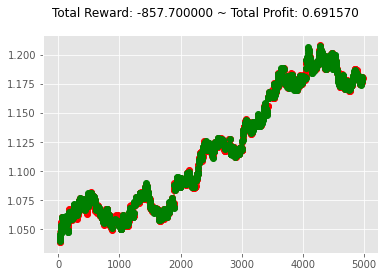

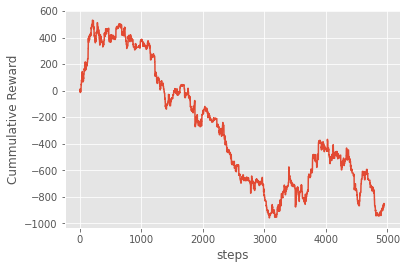

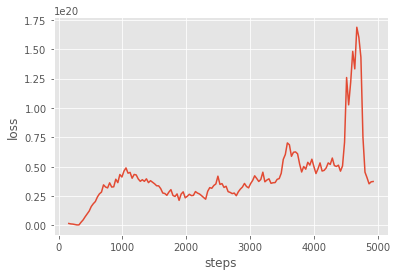

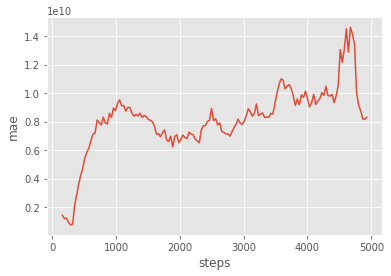

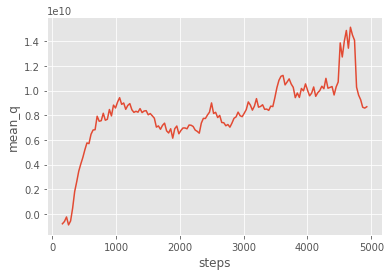

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 25s 25ms/step - reward: -11.3602 - cumulative_reward: 567.0939
train 6 completed. took 242.320 seconds, total_reward: 732.29999999996 total_profit: 0.7539041411609309
min reward: -107.29999999999906, max reward: 203.40000000000026, mean_reward: 0.14796928672458276


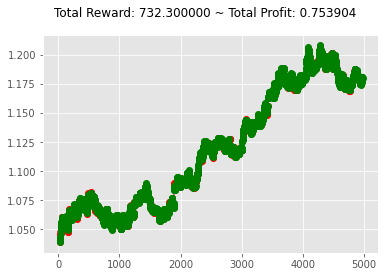

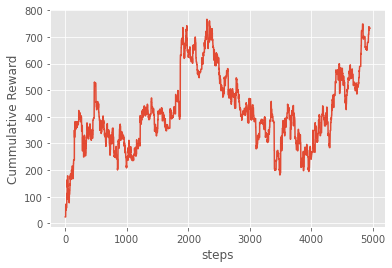

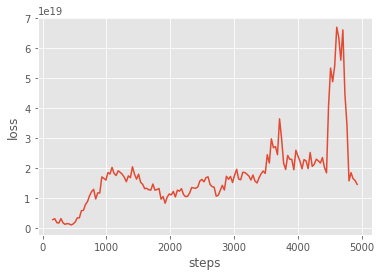

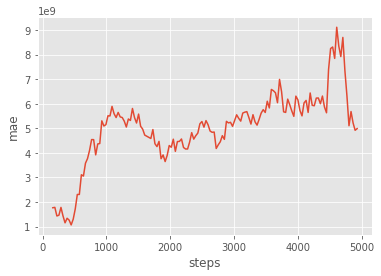

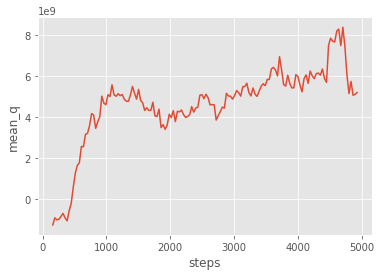

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 27ms/step - reward: 13.5128 - cumulative_reward: 292.2070
train 7 completed. took 295.317 seconds, total_reward: 309.600000000073 total_profit: 0.7314589564458461
min reward: -102.99999999999976, max reward: 143.90000000000347, mean_reward: 0.06255809254396302


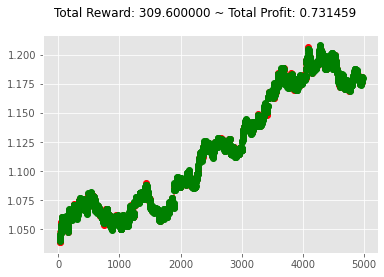

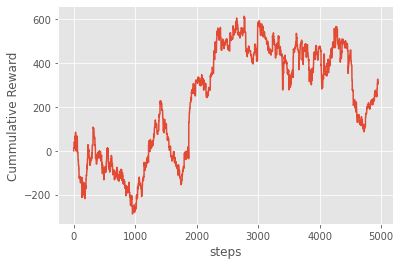

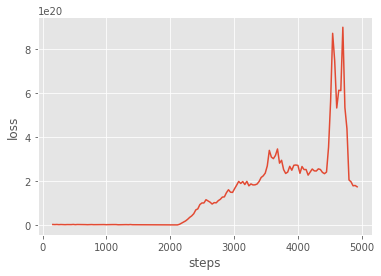

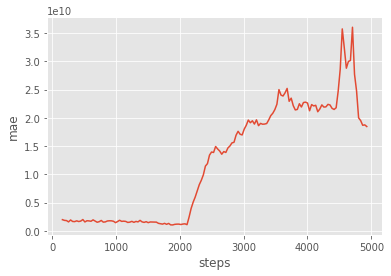

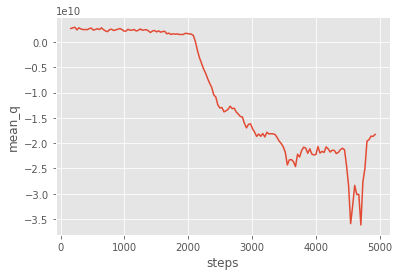

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 29s 29ms/step - reward: 22.9612 - cumulative_reward: 351.2742
train 8 completed. took 352.975 seconds, total_reward: 753.4000000001215 total_profit: 0.7419383376285215
min reward: -168.70000000000164, max reward: 97.69999999999834, mean_reward: 0.1522327742978625


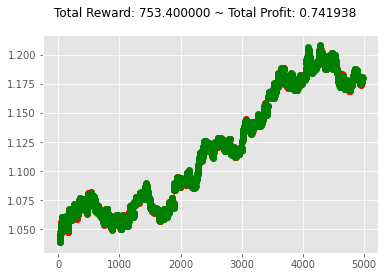

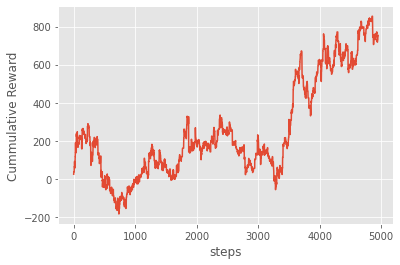

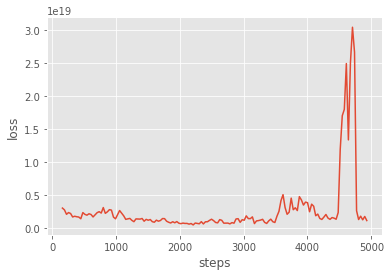

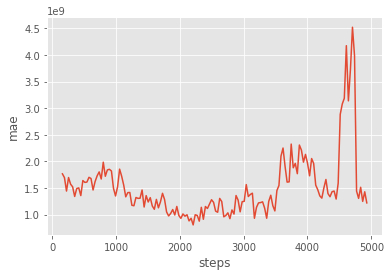

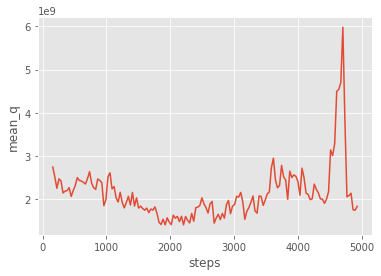

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 30s 31ms/step - reward: -9.7777 - cumulative_reward: 647.1311
train 9 completed. took 414.306 seconds, total_reward: 714.9000000001399 total_profit: 0.7327195109834516
min reward: -135.19999999999754, max reward: 143.90000000000347, mean_reward: 0.14445342493435845


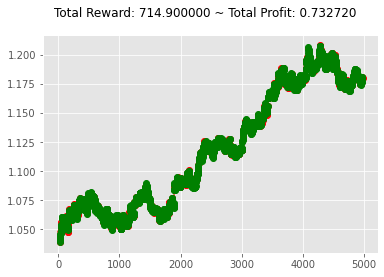

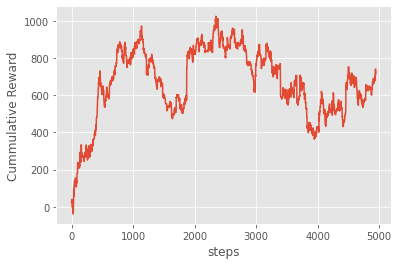

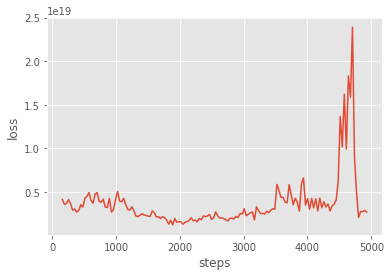

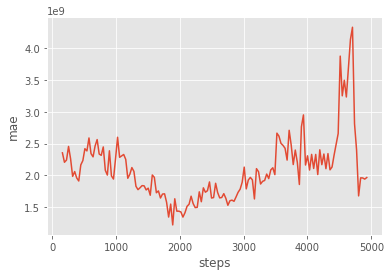

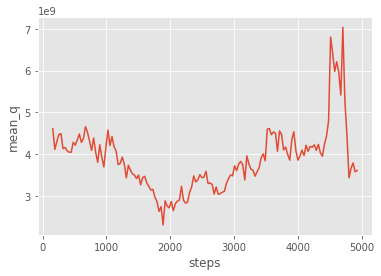

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 32s 32ms/step - reward: -17.8197 - cumulative_reward: 413.6267
train 10 completed. took 479.076 seconds, total_reward: 772.2999999998683 total_profit: 0.7319762290709299
min reward: -103.6999999999999, max reward: 179.60000000000198, mean_reward: 0.15605172762171515


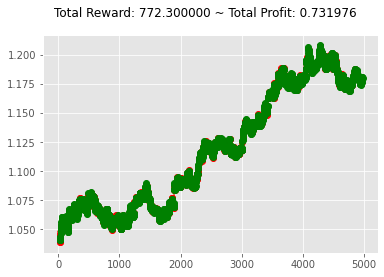

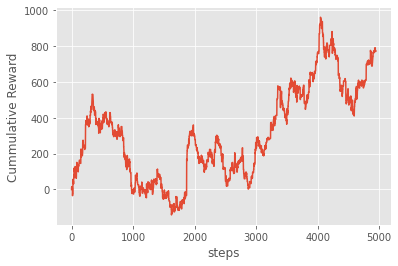

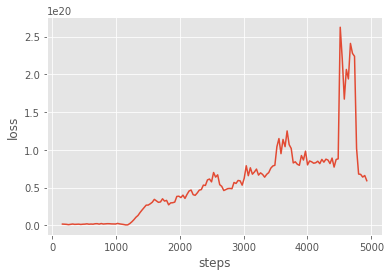

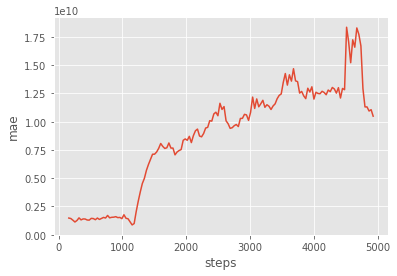

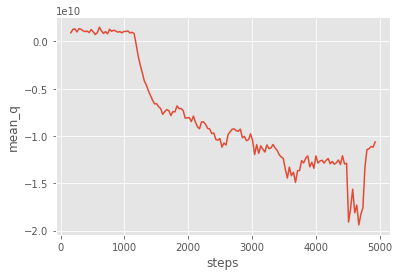

In [7]:
e = Evaluator(agent_creator, env_creator, name="ddpg-fullfeature")
e.train(repeat=10)

average of total_reward across trainings: [-98.13]


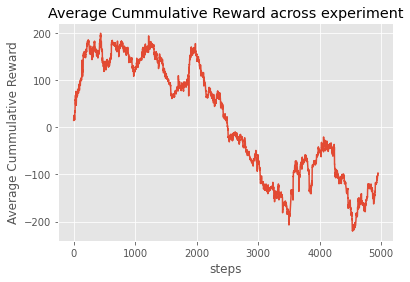

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
187/199 [===========================>..] - ETA: 0s - reward: -6.3866 - cumulative_reward: -66.6393Episode 1: reward: -136.500, steps: 999
test completed. total_reward: -136.5000000000526 total_profit: 0.941620048918625
min reward: -109.30000000000106, max reward: 65.69999999999965, mean_reward: -0.1366366366366893


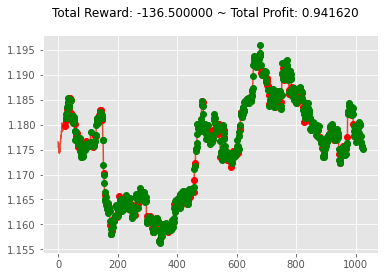

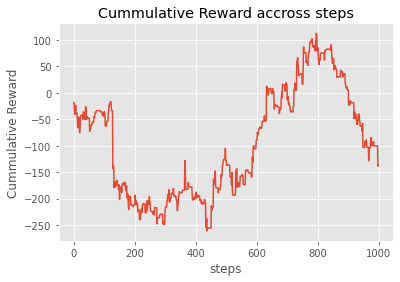

In [8]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=window_size))

### Kaggle Dataset 

In [6]:
from data import EURUSD_HOUR
from custom_env import ExternalDataFullFeature

window_size=24
def env_creator():
    return ExternalDataFullFeature(df=EURUSD_HOUR, window_size=window_size, frame_bound=(50, 80000))


env = env_creator()
env_shape = env.reset().shape
print("max possible profit: {}".format(env.max_possible_profit()))
def critic_actor():
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    obs = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Flatten()(obs)

    obs_1 = Dense(256, activation='relu')(obs)
    obs_1 = Dropout(0.2)(obs_1)
    obs_1 = Dense(64, activation='relu')(obs_1)
    obs_out = Dense(nb_actions, activation='softmax')(obs_1)
    actor = Model(inputs=[observation_input], outputs=obs_out)
    # print(actor.summary())

    obs_2 = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Flatten()(obs_2)

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(32, activation='linear')(action_input)

    x = Concatenate()([a1, obs])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    # print(critic.summary())
    return actor, critic, action_input

def agent_creator():
    actor, critic, action_input = critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])
    return agent


max possible profit: 2485856055592.9863


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2672s 167ms/step - reward: 0.4278 - cumulative_reward: 4913.1936
train 1 completed. took 2690.657 seconds, total_reward: 6839.700000000084 total_profit: 0.033764623698870344
min reward: -320.5999999999998, max reward: 438.0000000000006, mean_reward: 0.08555078862775124


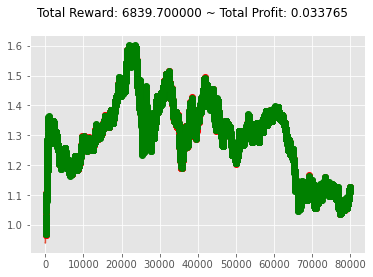

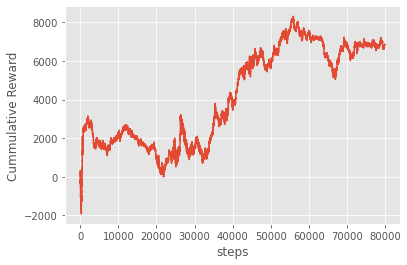

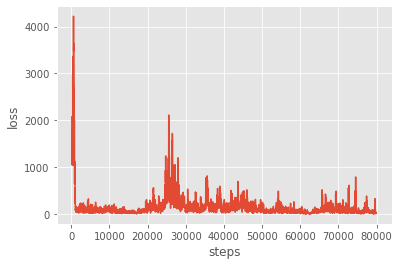

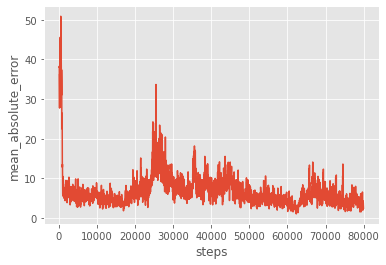

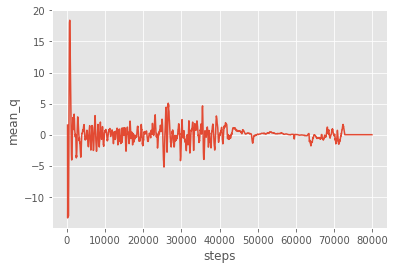

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2629s 164ms/step - reward: -22.1318 - cumulative_reward: 882.0219
train 2 completed. took 5336.961 seconds, total_reward: -508.5999999998808 total_profit: 0.023073631917309777
min reward: -278.00000000000045, max reward: 474.0000000000011, mean_reward: -0.0063615554916244205


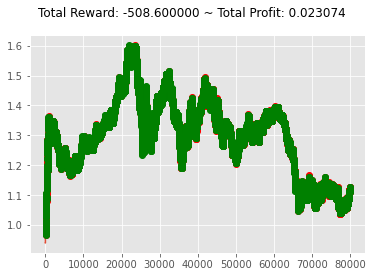

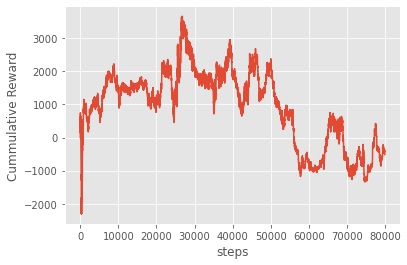

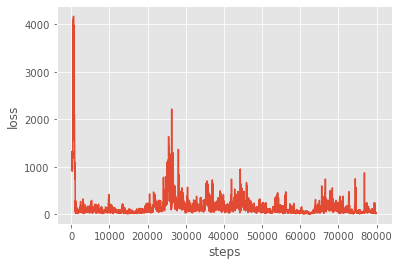

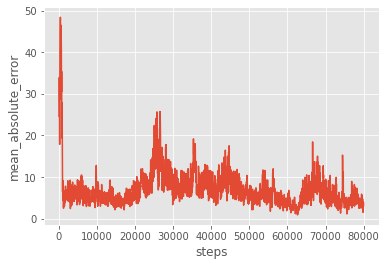

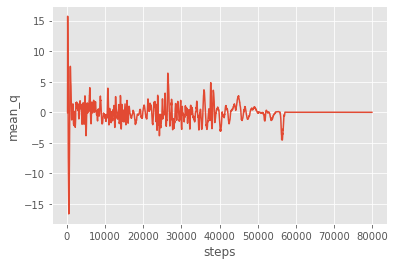

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2832s 177ms/step - reward: -0.2104 - cumulative_reward: -2636.7860
train 3 completed. took 8189.019 seconds, total_reward: -3363.5000000004648 total_profit: 0.021911903667111075
min reward: -399.1000000000011, max reward: 335.9999999999985, mean_reward: -0.0420705699883734


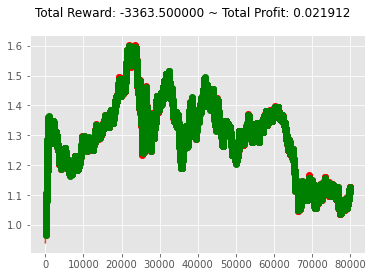

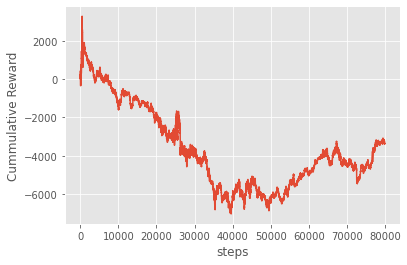

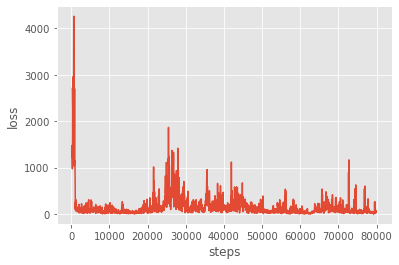

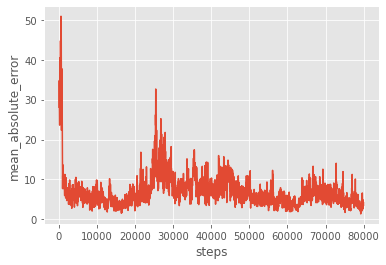

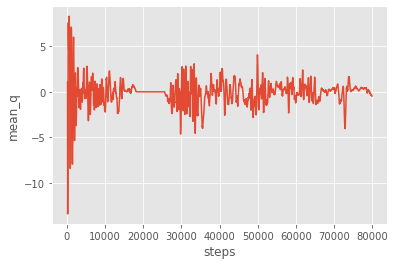

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2740s 171ms/step - reward: 28.5165 - cumulative_reward: -1690.5570
train 4 completed. took 10952.760 seconds, total_reward: -4533.6999999999425 total_profit: 0.02125535637613842
min reward: -697.9000000000002, max reward: 383.0, mean_reward: -0.05670740096811645


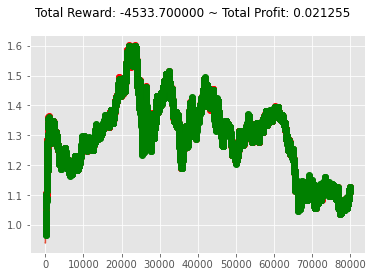

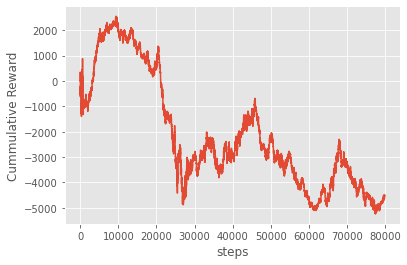

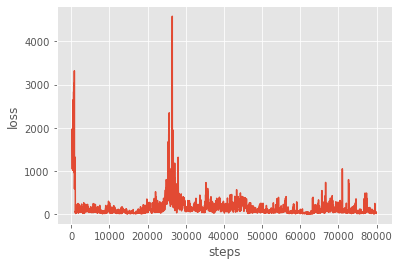

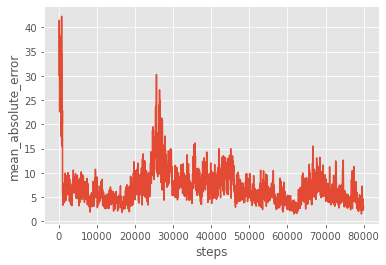

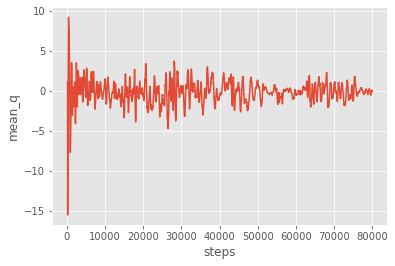

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2886s 180ms/step - reward: 3.5401 - cumulative_reward: 4142.4753
train 5 completed. took 13863.290 seconds, total_reward: 3838.800000000088 total_profit: 0.028042797204067743
min reward: -398.3999999999987, max reward: 343.0, mean_reward: 0.04801560995134508


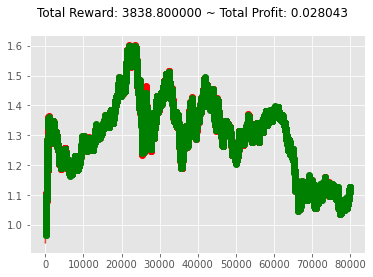

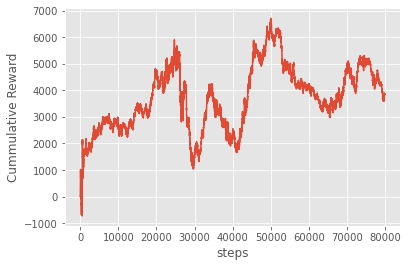

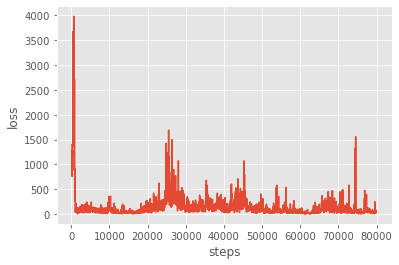

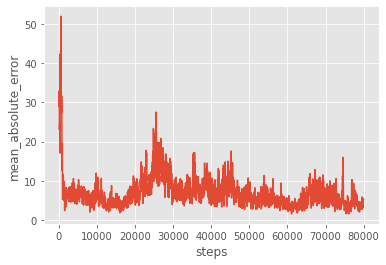

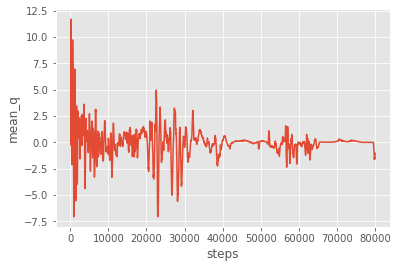

In [7]:
e = Evaluator(agent_creator, env_creator, name="ddpg-90k")
e.train(repeat=5)

average of total_reward across trainings: [454.54]


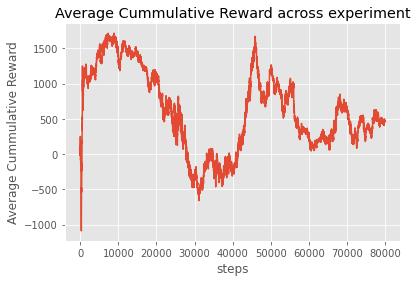

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 65s 32ms/step - reward: 15.7621 - cumulative_reward: 771.8295
Episode 1: reward: 1124.000, steps: 9999
test completed. total_reward: 1123.9999999999893 total_profit: 0.6299649608141025
min reward: -120.10000000000076, max reward: 126.69999999999737, mean_reward: 0.11241124112411134


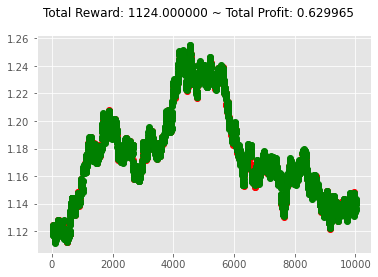

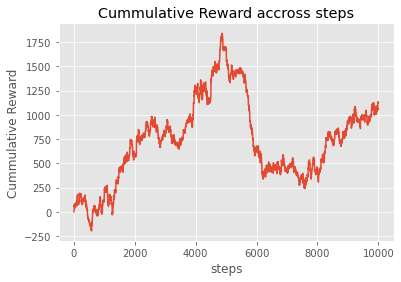

In [8]:
e.process_train_result()
e.test(ExternalDataFullFeature(df=EURUSD_HOUR, window_size=window_size, frame_bound=(80000, 90000)))